In [1]:
import mlflow
import mlflow.spacy
import mlflow.sklearn
import polars as pl
import seaborn as sns
import scipy
import duckdb
import numpy as np
import json
import timeit
import matplotlib.pyplot as plt

In [2]:
import os
import sys
from dotenv import load_dotenv
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))
from app.model_functions import run_BOW_on_line
from app.evaluation import reciprocal_rank, rank_results, precision_at_k
from app.data_handling.BOW import transform_ds_to_BOW
from app.data_handling.NER_parquet import (
process_ingredient,
transform_ingredients_to_tokens,
transform_data_to_tokens,
construct_ingredient_query,
ParquetDefinition,
create_parquet_file
)

load_dotenv()

True

In [3]:
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URL"))

In [4]:
with open("../../data/eval_data/processed_data.json", "r") as f:
    eval_ds = pl.read_json(f)

In [5]:
model_uri = 'models:/recipe_BOW@prod'
BOW_model = mlflow.sklearn.load_model(model_uri)

/home/naabzer/develop/recipe_tm/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
results_df = pl.DataFrame(
    schema={
        'Model': pl.String,
        'Eval_Task': pl.String,
        "MRR": pl.Float64,
        "P@3": pl.Float64,
        "Time_Tot": pl.Float64,
        "Time_Query": pl.Float64
    })

In [7]:
results_df

Model,Eval_Task,MRR,P@3,Time_Tot,Time_Query
str,str,f64,f64,f64,f64


# BOW Evaluation 

In [8]:
eval_ds = transform_ds_to_BOW(eval_ds, BOW_model)

In [9]:
eval_ds.head()

index,title,ingredients,google_search_query,main_food_items_and_preparations,important_ingredients_for_search,google_search_query_processed,tfidf
i64,str,list[str],str,list[str],list[str],struct[2],object
1461,"""Apricot Cake""","[""2 c. sugar"", ""4 eggs"", … ""1/2 c. chopped nuts (English or pecans)""]","""apricot cake recipe with baby …","[""sugar"", ""eggs"", … ""chopped nuts (English or pecans)""]","[""apricot baby food"", ""flour"", … ""Wesson oil""]","{""Apricot Cake"",[""baby food"", ""oil"", … ""cinnamon""]}","<Compressed Sparse Row sparse matrix of dtype 'float64' with 21 stored elements and shape (1, 126980)> Coords Values (0, 8689) 0.18368190086248304 (0, 10592) 0.1751061768342027 (0, 11307) 0.20405124421235452 (0, 26865) 0.19643847856827631 (0, 27702) 0.13648631984224308 (0, 38873) 0.18705595625647875 (0, 39815) 0.1992321192195883 (0, 43898) 0.11032351088222118 (0, 44266) 0.1796566692514706 (0, 58087) 0.5551961913746999 (0, 59488) 0.2872331989442519 (0, 80282) 0.21505802551943995 (0, 80910) 0.10859027341475272 (0, 86221) 0.18854864522564324 (0, 99135) 0.09459019471902082 (0, 105398) 0.12861447388991612 (0, 106088) 0.1409161193857687 (0, 110260) 0.09704922733518329 (0, 112690) 0.22149353908912242 (0, 117669) 0.2779445187813529 (0, 122930) 0.22847006186990454"
1490,"""Angel Delights""","[""1 c. miniature marshmallows"", ""1 c. broken pretzels"", … ""1 lb. almond bark""]","""angel delights recipe with mar…","[""miniature marshmallows"", ""broken pretzels"", … ""almond bark""]","[""marshmallows"", ""pretzels"", … ""almond bark""]","{""Angel Delights"",[""marshmallows"", ""pretzels"", … ""almond bark""]}","<Compressed Sparse Row sparse matrix of dtype 'float64' with 11 stored elements and shape (1, 126980)> Coords Values (0, 6768) 0.2127014519934178 (0, 12028) 0.3305314119142033 (0, 18402) 0.37469021959382043 (0, 28684) 0.27209291443570766 (0, 30536) 0.19336323513108022 (0, 43388) 0.3316514703677241 (0, 65634) 0.16116960968861724 (0, 71274) 0.3651459676737531 (0, 74495) 0.2718593045553501 (0, 86101) 0.35076461524826635 (0, 91531) 0.3569974891171025"
3374,"""Savory Sausage Casserole""","[""1 lb. bulk pork sausage"", ""1 c. uncooked rice"", … ""1/2 c. toasted halved or slivered blanched almonds""]","""sausage and rice casserole wit…","[""bulk pork sausage"", ""uncooked rice"", … ""toasted halved or slivered blanched almonds""]","[""pork sausage"", ""rice"", … ""almonds""]","{""Savory Sausage Casserole"",[""rice"", ""chicken noodle soup mix"", ""almonds""]}","<Compressed Sparse Row sparse matrix of dtype 'float64' with 26 stored elements and shape (1, 126980)> Coords Values (0, 6786) 0.24945320700271945 (0, 15088) 0.26107309128618433 (0, 19233) 0.24583264902840038 (0, 23892) 0.1561150210668319 (0, 25669) 0.12479944623988158 (0, 26865) 0.21668423759551342 (0, 34717) 0.3494340601418532 (0, 42969) 0.14310867436922448 (0, 51897) 0.2923366490863447 (0, 65634) 0.1293685516819533 (0, 79664) 0.18679739606263396 (0, 81454) 0.11592549924447773 (0, 82783) 0.12061733168395841 (0, 89089) 0.14257620463062023 (0, 90333) 0.16636635959976726 (0, 96054) 0.15255832659987625 (0, 100020) 0.12983465767578653 (0, 100168) 0.1760956112225869 (0, 105064) 0.19222309929862494 (0, 105202) 0.2920630095445465 (0, 106814) 0.14770670100340375 (0, 106991) 0.17196126288047037 (0, 113237) 0.11464229188539002 (0, 115564) 0.2341521659089565 (0, 118871) 0.1933052744087343 (0, 122445) 0.12844333624517307"
7006,"""Zemakove Knedliky A Kysele Zel…","[""2 c. mashed potatoes"", ""1/2 tsp. salt"", … ""1 1/2 c. flour""]","""potato dumplings with sauerkra…","[""mashed potatoes"", ""salt"", … ""flour""]","[""mashed potatoes"", ""sauerkraut"", … ""egg""]","{""Zemakove Knedliky A Kysele Zeli(Potato Dumplings With Sauerkraut) "",[""sauerkraut"", ""mashed potatoes""]}","<Compressed Sparse Row sparse matrix of dtype 'float64' with 10 stored elements and shape (1, 126980)> Coords Values (0, 11307) 0.3981186101405156 (0, 38785) 0.20937491027351302 (0, 43898) 0.2152490811207347

In [10]:
# Run once to download model, to put that time into the time measurement
emb_query = run_BOW_on_line("pecans", model_uri)

### Identity query
Here we use the original ingredients as the input to the model. Since this is also what the model is trained on, it should give close to perfect results

In [11]:
tot_rr = 0
tot_prec_at_3 = 0
tot_evals = 0
start = timeit.default_timer()
for index, title, ingredient_list in eval_ds.select('index', 'title', 'ingredients').iter_rows():
    emb_query = run_BOW_on_line(title + " " + "\n".join(ingredient_list), model_uri)
    ranked_ds = rank_results(eval_ds, emb_query)
    tot_rr += reciprocal_rank(ranked_ds, index)
    tot_prec_at_3 += precision_at_k(ranked_ds, index)
    tot_evals += 1
time = timeit.default_timer() - start

In [12]:
mrr = tot_rr/tot_evals
mprec3 = tot_prec_at_3 / tot_evals
result_data = {
    "Model": ['bow'],
    'Eval_Task': ['identity'],
    "MRR": [mrr],
    "P@3": [mprec3],
    "Time_Tot": time,
    "Time_Query": time/tot_evals
}
result_df = pl.DataFrame(result_data)
results_df = results_df.vstack(result_df)

### LLM task 1 - Main food items and preparations
Here the BOW should perform worse

In [13]:
tot_rr = 0
tot_prec_at_3 = 0
tot_evals = 0
start = timeit.default_timer()
for index, ingredient_list in eval_ds.select('index', 'main_food_items_and_preparations').iter_rows():
    emb_query = run_BOW_on_line("\n".join(ingredient_list), model_uri)
    ranked_ds = rank_results(eval_ds, emb_query)
    tot_rr += reciprocal_rank(ranked_ds, index)
    tot_prec_at_3 += precision_at_k(ranked_ds, index)
    tot_evals += 1
time = timeit.default_timer() - start

In [14]:
llm1_mrr = tot_rr/tot_evals
print(f"LLM Task 1, MRR: {llm1_mrr}")
llm1_mean_prec_at_3 = tot_prec_at_3 / tot_evals
print(f"LLM Task 2, P@3: {llm1_mean_prec_at_3}")
result_df

LLM Task 1, MRR: 0.9604589799089801
LLM Task 2, P@3: 0.983


Model,Eval_Task,MRR,P@3,Time_Tot,Time_Query
str,str,f64,f64,f64,f64
"""bow""","""identity""",0.982942,0.994,31.138151,0.031138


In [15]:
mrr = tot_rr/tot_evals
mprec3 = tot_prec_at_3 / tot_evals
result_data = {
    "Model": ['bow'],
    'Eval_Task': ['llm1'],
    "MRR": [mrr],
    "P@3": [mprec3],
    "Time_Tot": time,
    "Time_Query": time/tot_evals
}
result_df = pl.DataFrame(result_data)
results_df = results_df.vstack(result_df)

### LLM task 2 - Important ingredients for search
Here the BOW should perform worse

In [16]:
tot_rr = 0
tot_prec_at_3 = 0
tot_evals = 0
start = timeit.default_timer()
for index, ingredient_list in eval_ds.select('index', 'important_ingredients_for_search').iter_rows():
    emb_query = run_BOW_on_line("\n".join(ingredient_list), model_uri)
    ranked_ds = rank_results(eval_ds, emb_query)
    tot_rr += reciprocal_rank(ranked_ds, index)
    tot_prec_at_3 += precision_at_k(ranked_ds, index)
    tot_evals += 1
time = timeit.default_timer() - start

In [17]:
mrr = tot_rr/tot_evals
mprec3 = tot_prec_at_3 / tot_evals
result_data = {
    "Model": ['bow'],
    'Eval_Task': ['llm2'],
    "MRR": [mrr],
    "P@3": [mprec3],
    "Time_Tot": time,
    "Time_Query": time/tot_evals
}
result_df = pl.DataFrame(result_data)
results_df = results_df.vstack(result_df)

### LLM task 3 - Google query, processed
Here the BOW should perform worse

In [18]:
tot_rr = 0
tot_prec_at_3 = 0
tot_evals = 0
start = timeit.default_timer()
for index, ingredient_list in eval_ds.select('index', 'google_search_query_processed').iter_rows():
    emb_query = run_BOW_on_line(ingredient_list['title'] + " "+ "\n".join(ingredient_list['ingredients']), model_uri)
    ranked_ds = rank_results(eval_ds, emb_query)
    tot_rr += reciprocal_rank(ranked_ds, index)
    tot_prec_at_3 += precision_at_k(ranked_ds, index)
    tot_evals += 1
time = timeit.default_timer() - start

In [19]:
mrr = tot_rr/tot_evals
mprec3 = tot_prec_at_3 / tot_evals
result_data = {
    "Model": ['bow'],
    'Eval_Task': ['llm3'],
    "MRR": [mrr],
    "P@3": [mprec3],
    "Time_Tot": time,
    "Time_Query": time/tot_evals
}
result_df = pl.DataFrame(result_data)
results_df = results_df.vstack(result_df)

# NER DB 
Currently this should perform pretty bad, since there is no ranking function, the metrics would be pretty random for any result where you have more than a few results after filtering.

In [20]:
model_uri = "models:/recipe_NER@prod"
ner = mlflow.spacy.load_model(model_uri=model_uri)

### Identity query

In [21]:
tokens, preps, optionals = transform_data_to_tokens(eval_ds['ingredients'], ner)

In [22]:
inp = [
    ParquetDefinition(data=tokens, name="tokens"),
    ParquetDefinition(data=preps, name="preps", is_map=True),
    ParquetDefinition(data=optionals, name="optionals")
]
create_parquet_file("eval_test.parquet", eval_ds.select(pl.exclude('tfidf')), inp)

'eval_test.parquet'

In [23]:
tot_rr = 0
tot_prec_at_3 = 0
tot_evals = 0
tot_evals = 0
start = timeit.default_timer()
for index, query in eval_ds.select('index', 'ingredients').iter_rows():
    query_obj = transform_ingredients_to_tokens(query, ner)
    sql = construct_ingredient_query('eval_test.parquet', query_obj['foods'], query_obj['preps'])
    try:
        results = duckdb.sql(sql).pl()
        tot_rr += reciprocal_rank(results, index)
        tot_prec_at_3 += precision_at_k(results, index)
        tot_evals += 1
    except:
        continue
time = timeit.default_timer() - start

In [24]:
mrr = tot_rr/tot_evals
mprec3 = tot_prec_at_3 / tot_evals
result_data = {
    "Model": ['ner'],
    'Eval_Task': ['identity'],
    "MRR": [mrr],
    "P@3": [mprec3],
    "Time_Tot": time,
    "Time_Query": time/tot_evals
}
result_df = pl.DataFrame(result_data)
results_df = results_df.vstack(result_df)

### LLM task 1

In [25]:
tot_rr = 0
tot_prec_at_3 = 0
tot_evals = 0
start = timeit.default_timer()
for index, query in eval_ds.select('index', 'main_food_items_and_preparations').iter_rows():
    query_obj = transform_ingredients_to_tokens(query, ner)
    sql = construct_ingredient_query('eval_test.parquet', query_obj['foods'], query_obj['preps'])
    try:
        results = duckdb.sql(sql).pl()
        tot_rr += reciprocal_rank(results, index)
        tot_prec_at_3 += precision_at_k(results, index)
        tot_evals += 1
    except:
        continue
time = timeit.default_timer() - start

In [26]:
mrr = tot_rr/tot_evals
mprec3 = tot_prec_at_3 / tot_evals
result_data = {
    "Model": ['ner'],
    'Eval_Task': ['llm1'],
    "MRR": [mrr],
    "P@3": [mprec3],
    "Time_Tot": time,
    "Time_Query": time/tot_evals
}
result_df = pl.DataFrame(result_data)
results_df = results_df.vstack(result_df)

### LLM task 2

In [27]:
tot_rr = 0
tot_prec_at_3 = 0
tot_evals = 0
start = timeit.default_timer()
for index, query in eval_ds.select('index', 'important_ingredients_for_search').iter_rows():
    query_obj = transform_ingredients_to_tokens(query, ner)
    sql = construct_ingredient_query('eval_test.parquet', query_obj['foods'], query_obj['preps'])
    try:
        results = duckdb.sql(sql).pl()
        tot_rr += reciprocal_rank(results, index)
        tot_prec_at_3 += precision_at_k(results, index)
        tot_evals += 1
    except:
        continue
time = timeit.default_timer() - start

In [28]:
mrr = tot_rr/tot_evals
mprec3 = tot_prec_at_3 / tot_evals
result_data = {
    "Model": ['ner'],
    'Eval_Task': ['llm2'],
    "MRR": [mrr],
    "P@3": [mprec3],
    "Time_Tot": time,
    "Time_Query": time/tot_evals
}
result_df = pl.DataFrame(result_data)
results_df = results_df.vstack(result_df)

### LLM Task 3

In [29]:
tot_rr = 0
tot_prec_at_3 = 0
tot_evals = 0
start = timeit.default_timer()
for index, query in eval_ds.select('index', 'google_search_query_processed').iter_rows():
    query_obj = transform_ingredients_to_tokens(query['ingredients'], ner)
    sql = construct_ingredient_query('eval_test.parquet', query_obj['foods'], query_obj['preps'])
    try:
        results = duckdb.sql(sql).pl()
        tot_rr += reciprocal_rank(results, index)
        tot_prec_at_3 += precision_at_k(results, index)
        tot_evals += 1
    except:
        continue
time = timeit.default_timer() - start

In [30]:
mrr = tot_rr/tot_evals
mprec3 = tot_prec_at_3 / tot_evals
result_data = {
    "Model": ['ner'],
    'Eval_Task': ['llm3'],
    "MRR": [mrr],
    "P@3": [mprec3],
    "Time_Tot": time,
    "Time_Query": time/tot_evals
}
result_df = pl.DataFrame(result_data)
results_df = results_df.vstack(result_df)

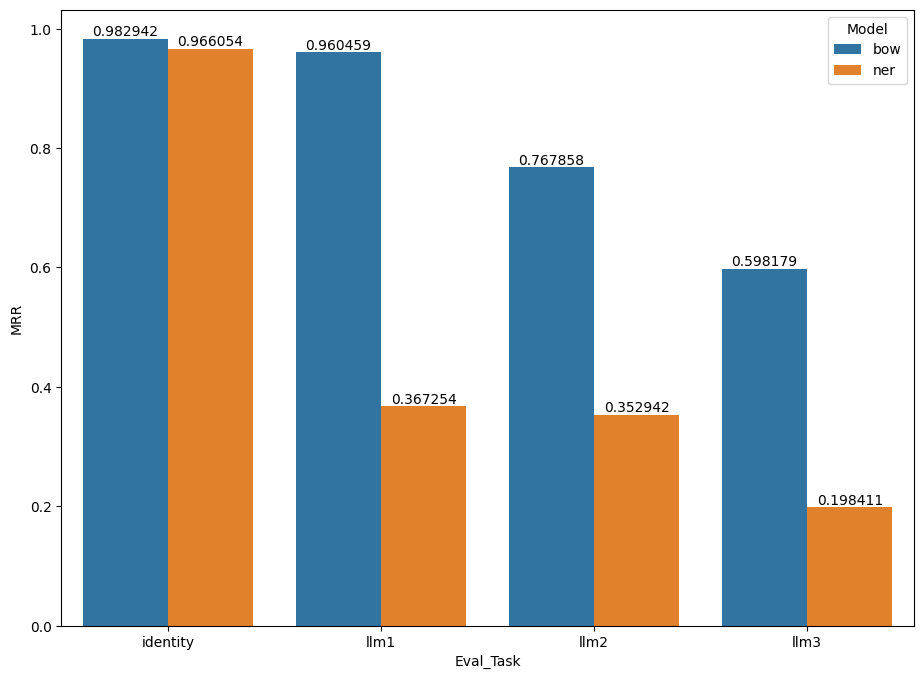

In [31]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='MRR', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

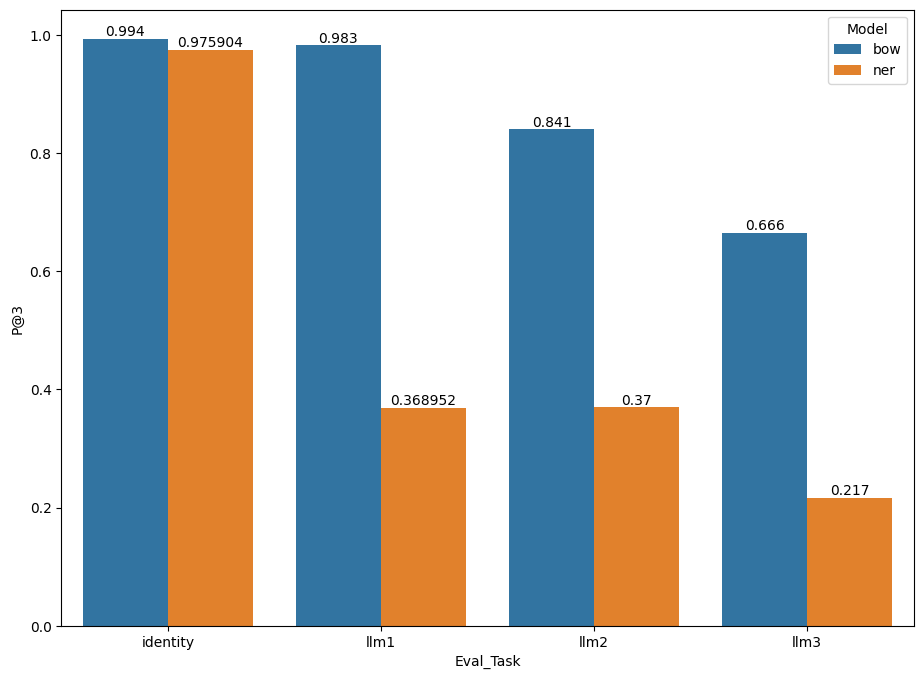

In [32]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='P@3', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

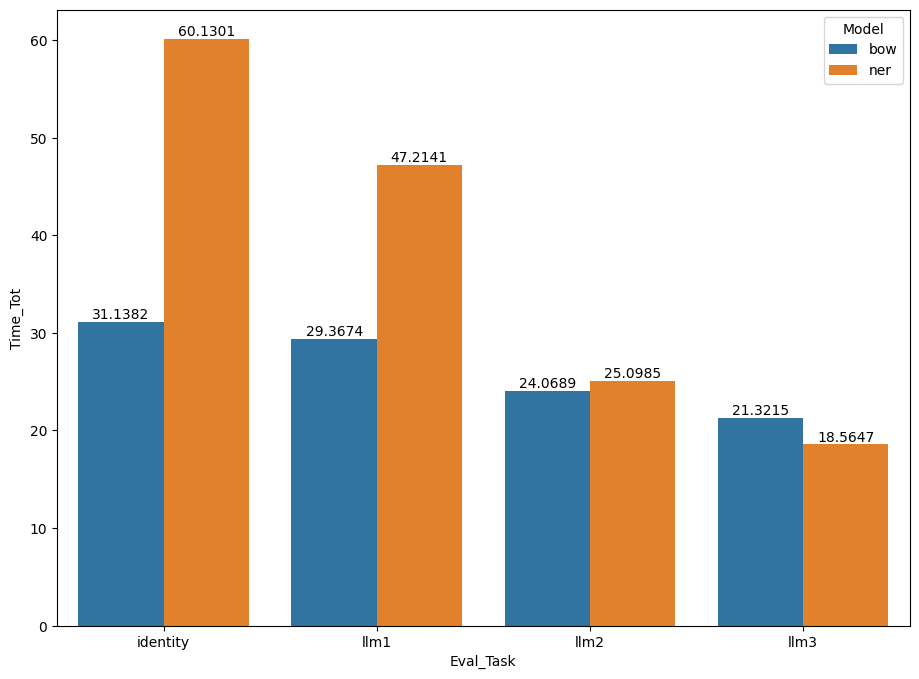

In [33]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='Time_Tot', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

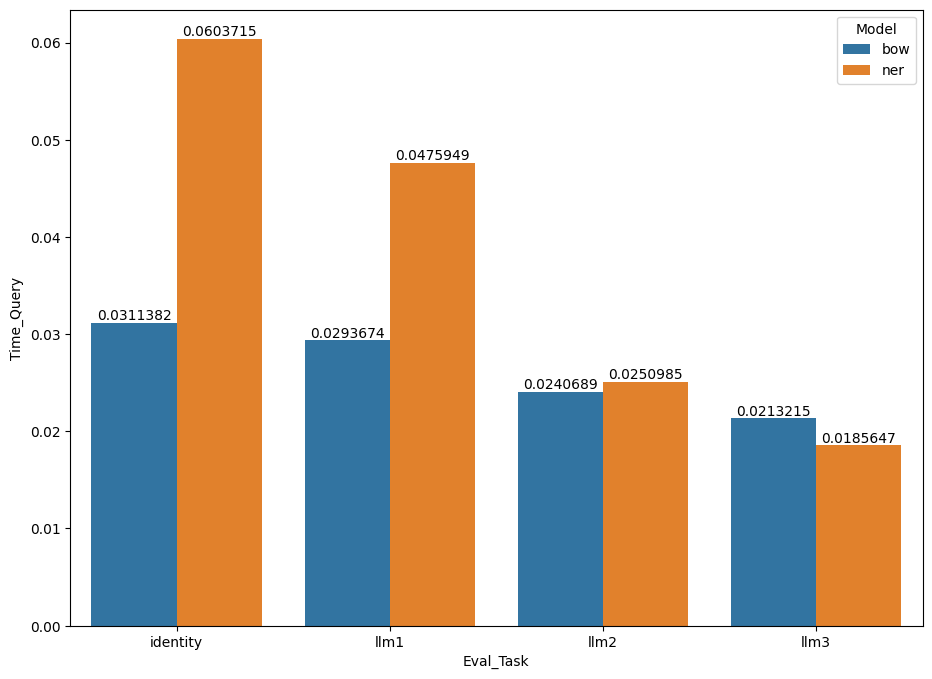

In [34]:
plt.figure(figsize=(11,8))
ax = sns.barplot(results_df, x='Eval_Task', y='Time_Query', hue='Model')

for cont in ax.containers:
    ax.bar_label(cont)

In [ ]:
results_df.write_parquet('../../data/results/first